In [176]:
import os
import sys
import pandas as pd
import numpy as np
import logging
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from abc import ABC, abstractmethod
from typing import Dict, Tuple, List, Self, Callable, Any, Type, Union
from datetime import datetime

from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, LearningCurveDisplay, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix, make_scorer, cohen_kappa_score

In [5]:
# logger = logging.getLogger(__name__)
# logging.basicConfig(
#     level=logging.INFO,
#     format="%(asctime)s - %(name)s - %(levelname)s: %(message)s",
#     datefmt="%Y-%m-%d:%H:%M:%S",
#     handlers=[
#         logging.FileHandler(Path(config.LOGS_DIR, "data_processing.log"), mode="w+"),
#         logging.StreamHandler(),
#     ],
# )

In [233]:
RANDOM_SEED = 42
IMAGE_DIR = 'images/'
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
LOGS_DIR = 'logs/'

class Config:
    RANDOM_SEED = 42
    IMAGE_DIR = "images/"
    RESULTS_DIR = "results/"
    DATA_DIR = "data/"
    LOGS_DIR = "logs/"

    ML_PREPROCESS_PARAMS = {
        "shuffle": True,
        "stratify": True,
        "test_size": 0.3,
        "class_weights": None,
    }

    def __init__(self, verbose: bool = False):
        self.VERBOSE = verbose

def get_directory(child_dir: str) -> Path:
    path = Path.cwd() / child_dir
    try:
        path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        print("Folder is already there")
    else:
        print("Folder was created")

    return path

# Config.RANDOM_SEED
config = Config()
get_directory(config.IMAGE_DIR + "ss")

Folder is already there


PosixPath('/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/ss')

In [240]:
class Dataset:
    def __init__(self, data_path: str, data_delimiter: str, config: Config):
        self.data_path: str = (
            data_path  # CHange to dataset_path and make name a property
        )
        self.data: pd.DataFrame = None
        self.delimiter: str = data_delimiter
        self.config: Type[Config] = config
        self.verbose: bool = config.VERBOSE
        self.outliers = None

    @property
    def name(self) -> str:
        return self.data_path.replace(".csv", "").replace("-", "_")

    def load_data(self, verbose: bool = False, **kwargs) -> None:
        """
        Loads data from the specified path.
        """
        try:
            data_path = Path(self.config.DATA_DIR, self.data_path)
            self.data = pd.read_csv(data_path, **kwargs)
            if verbose:
                logger.info(f"Loading Dataset: {self.name}")

        except FileNotFoundError:
            print(f"Dataset: {self.name} not found in location: {data_path}")

        logger.info("Data loaded successfully")
        logger.info(
            f"Number of Rows: {len(self.data)} | Number of Features: {len(self.data.columns)}"
        )

    def summary_statistics(self, target_col: str, normalize_counts=True) -> None:
        """Provides summary statistics of all columns"""
        if self.data is None or self.data.empty:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method"
            )
        else:
            target_class_dist = (
                self.data[target_col]
                .value_counts(normalize=normalize_counts)
                .sort_index()
                .reset_index()
                .style.format({"proportion": "{:,.2%}"})
                .to_string()
            )
            # return target_class_dist
            summary_df = self.data.describe(
                include="all", percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]
            ).round(2)

            if self.verbose:
                logger.info(
                    "Target Column: {} | Class Distribution: {}".format(
                        target_col, target_class_dist
                    )
                )
                logger.info("Data Summary: {}".format(summary_df))

    def check_missing_values(self):
        """Checks for any missing values in the dataset."""
        has_nulls = self.data.isnull().values.any()
        if has_nulls:
            logger.warning("Warning Missing Values Detected")

    def check_outliers(self):
        """
        Detects outliers in each column of the DataFrame using the IQR method.

        Args:
        data (pd.DataFrame): The input DataFrame.

        Returns:
        dict: A dictionary where keys are column names and values are lists of indices of outliers.
        """
        if self.data is not None or not self.data.empty:
            numeric_cols = self.data.select_dtypes(include=[np.number]).columns
            outliers_dict = {}

            for col in numeric_cols:
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outlier_indices = self.data.index[
                    (self.data[col] < lower_bound) | (self.data[col] > upper_bound)
                ].tolist()

                if outlier_indices:
                    outliers_dict[col] = outlier_indices

            logger.info(f"Outliers Detected in columns: {list(outliers_dict.keys())}")
            return outliers_dict
        else:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method."
            )

    def cast_datatypes(self, column_type_map):
        """Casts datatypes to the appropriate formats based on the data content"""
        if self.data is not None or not self.data.empty:
            pass
        else:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method"
            )

    def create_train_test_split(self, target_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

        X = self.data.loc[:, self.data.columns != target_col]
        y = self.data[target_col]

        stratify = y if self.config.ML_PREPROCESS_PARAMS["shuffle"] else None
        X_TRAIN, X_TEST, y_train, y_test = train_test_split(
            X,
            y,
            random_state=self.config.RANDOM_SEED,
            test_size=self.config.ML_PREPROCESS_PARAMS["test_size"],
            shuffle=self.config.ML_PREPROCESS_PARAMS["shuffle"],
            stratify=stratify,
        )
        if self.verbose:
            logger.info(
                f"Train Set Size: {len(X_TRAIN)} | Test Set Size: {len(X_TEST)}"
            )

        return X_TRAIN, X_TEST, y_train, y_test, X, y

    def scale_data(self, x_train, x_test, y_train, y_test):
        """
        TODO: Add functionality for Normalization or MinMaxScaling
        _summary_

        Args:
            x_train (_type_): _description_
            x_test (_type_): _description_
            y_train (_type_): _description_
            y_test (_type_): _description_
        """
        pass

    def run(self, stratify_col: str, target_col: str, test_size: float):
        self.load_data(verbose=self.verbose, delimiter=self.delimiter)
        self.summary_statistics(target_col=target_col)
        self.check_missing_values()
        self.outliers = self.check_outliers()

        X_TRAIN, X_TEST, y_train, y_test, X, y = self.create_train_test_split(
            target_col
        )

########################################################################

config = Config()
wine_data = Dataset("winequality-white.csv", data_delimiter=";", config=config)
# .run(target_col="quality")
wine_data.load_data(delimiter=';')
# wine_data.data
wine_data.summary_statistics('quality')
# wine_data.check_missing_values()
# outliers_dict = wine_data.check_outliers()

target_col = 'quality'
# X_TRAIN, X_TEST, y_train, y_test, X, y = wine_data.create_train_test_split(target_col)

In [249]:
target_class_dist = (
    wine_data.data[target_col]
    .value_counts(normalize=True)
    .sort_index()
    .reset_index()
    .style.hide().format({"proportion": "{:,.2%}"})
)
target_class_dist

quality,proportion
3,0.41%
4,3.33%
5,29.75%
6,44.88%
7,17.97%
8,3.57%
9,0.10%


0 fixed acidity
1 volatile acidity
2 citric acid
3 residual sugar
4 chlorides
5 free sulfur dioxide
6 total sulfur dioxide
7 density
8 pH
9 sulphates
10 alcohol


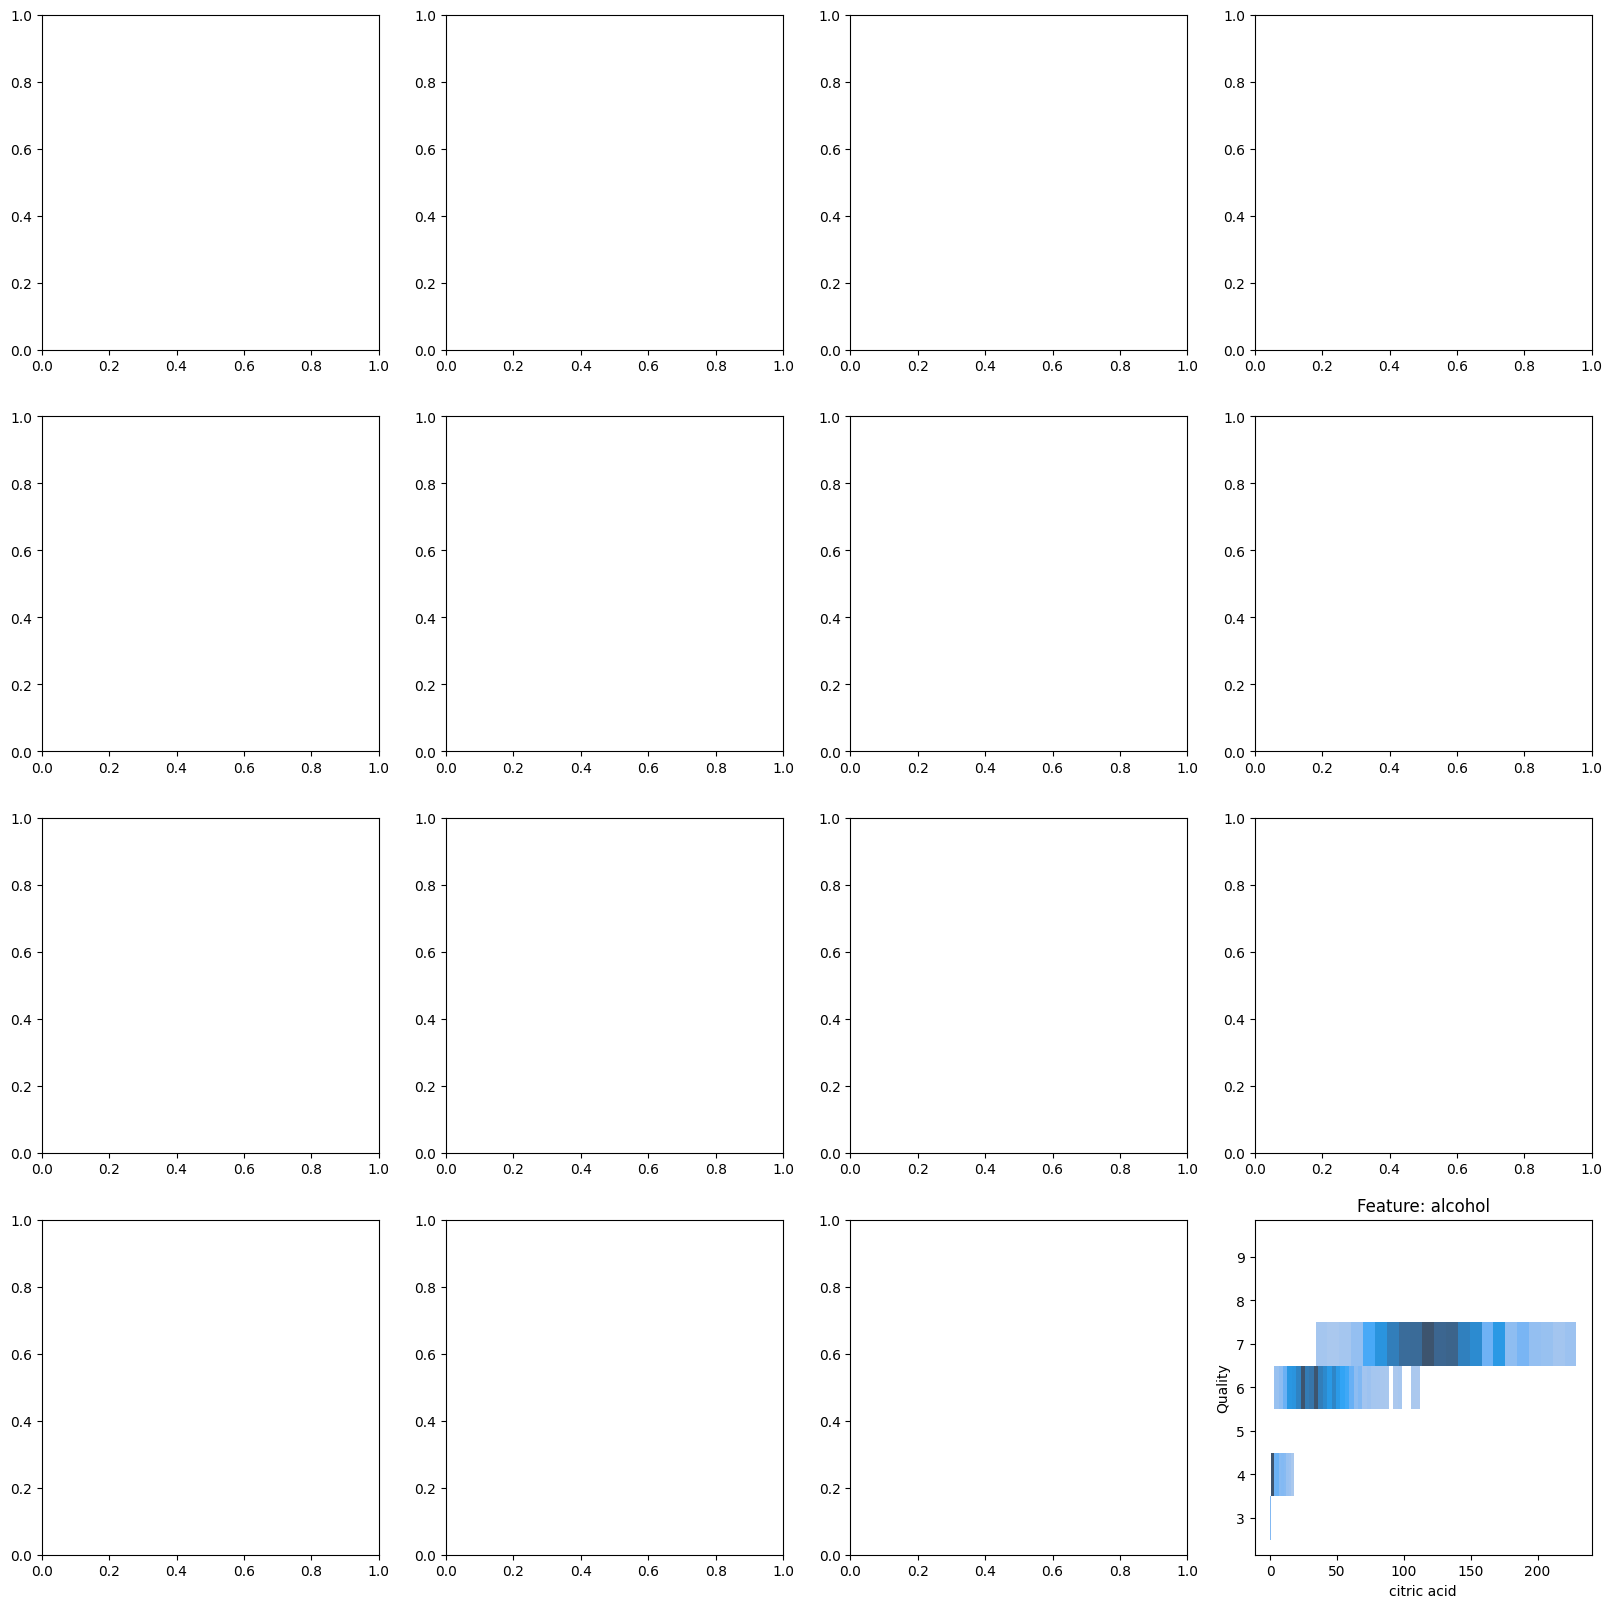

In [69]:
features = list(wine_data.data.loc[:, wine_data.data.columns != 'quality'].columns)

# create the figure
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

# flatten the axes to make it easier to index
axes = axes.flatten()

df = wine_data.data
# iterate through the column values, and use i to index the axes
for i, col in enumerate(X_TRAIN.columns):
    print(i, col)
    
    # seclect the column to be plotted
    data = df[df['quality'] == i + 1]

    x_data = data[col]
    target = data['quality']
    
    # plot the actual price against the features
    axes[i] = sns.histplot(x=x_data, y=target)
    
    # # plot predicted prices against the features
    # axes[i].scatter(x=data, y=ypred_train, c='pink', s=20, ec='white', alpha=0.5, label='predicted')

    # set the title and ylabel
    axes[i].set(title=f'Feature: {df.columns[i]}', ylabel='Quality')

# set a single legend
# axes[12].legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')

# # delete the last 3 unused axes
# for v in range(13, 16):
#     fig.delaxes(axes[v])

plt.show()

In [71]:
# Initialize the FacetGrid
# g = sns.FacetGrid(wine_data.data, col=features, col_wrap=2, hue='quality', height=4, aspect=1.5)

# # Map the scatterplot onto the grid
# g.map(sns.scatterplot, 'Value', target)

# # Add legends
# g.add_legend()

# plt.show()

In [220]:
class BaseClassifier(ClassifierMixin, BaseEstimator, ABC):
    def __init__(
        self,
        model: BaseEstimator,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
        seed: int,
        verbose=False,
    ):
        self.model = model
        self.config = config
        self.param_grid = param_grid
        self.eval_metric = eval_metric
        self.seed = seed
        self.verbose = config.VERBOSE

    @property
    def name(self) -> str:
        return self.__class__.__name__

    @property
    def classes_(self):
        return self._learner.classes_

    @property
    def n_classes_(self):
        return self._learner.n_classes_

    @property
    @abstractmethod
    def name(self) -> str:
        pass

    @property
    def unique_hyperparameters(self) -> List[str]:
        return list(self.param_grid.keys())

    def get_params(self, deep=True) -> Dict[str, Any]:
        """
        Get the current parameters for the learner. This passes the call back to the learner from learner()

        :param deep: If true, fetch deeply
        :return: The parameters
        """
        return self.model.get_params(deep)

    def set_params(self, **params) -> None:
        """
        Set the current parameters for the learner. This passes the call back to the learner from learner()

        :param params: The params to set
        :return: self
        """
        print(f"New Parameters Set: {params}")
        self.model.set_params(**params)

    def get_scorer(self, metric_name: str) -> Callable:
        """
        Given a metric name, return the corresponding sklearn scoring function

        :param metric_name: A string representing the metric name (e.g., 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'confusion_matrix')
        :return: A callable scoring function from sklearn.metrics
        """
        scorers = {
            "accuracy": accuracy_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
            "fbeta": fbeta_score,
            "roc_auc": roc_auc_score,
        }

        if metric_name in scorers:
            return make_scorer(scorers[metric_name])
        else:
            raise ValueError(
                f"Unknown metric name: {metric_name}. Valid options are: {list(scorers.keys())}"
            )

    @abstractmethod
    def fit(self, X, y, verbose=True) -> Self:
        pass

    @abstractmethod
    def predict(self, X, y) -> Self:
        pass

    @abstractmethod
    def plot_learning_curve(self, learner: BaseEstimator) -> None:
        pass

    @abstractmethod
    def plot_validation_curve(self, learner: BaseEstimator) -> None:
        pass

    @abstractmethod
    def plot_training_run_time(self, learner: BaseEstimator) -> None:
        pass


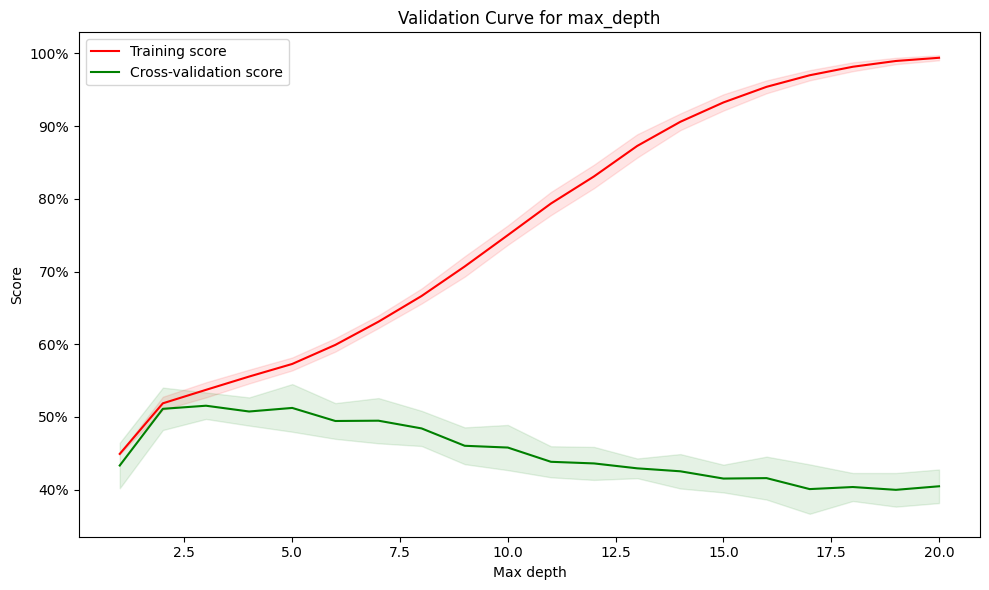

New Parameters Set: {'max_depth': 3}


In [222]:
class DTClassifier(BaseClassifier):
    """TODO: Add default params for DT"""

    def __init__(
        self,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
    ):
        super().__init__(
            model=DecisionTreeClassifier(random_state=config.RANDOM_SEED),
            config=config,
            param_grid=param_grid,
            eval_metric=eval_metric,
            seed=config.RANDOM_SEED,
            verbose=config.VERBOSE,
        )

    @property
    def name(self) -> str:
        """Returns a human readable name of the ML algorithm used

        Returns:
            str: I.e. Decision Tree Classifier
        """
        return self.__class__.__name__

    def fit(self, X: np.ndarray, y: np.array):
        """Fits the underlying estimator/model to the data

        Args:
            X np.array: Represents the independentfeatures used to train the model
            y np.array: Represents the target/response variable
            verbose (bool, optional): Flag to log additional information to the console

        Returns:
            DTClassifier: Returns the fitted model
        """
        if self.verbose:
            print("Fitting the model...")
        self.model.fit(X, y)
        if self.verbose:
            print("Model fitting completed.")
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Returns the mean response given a set of independent features

        Args:
            X (np.ndarray): Represents the independent features

        Returns:
            np.ndarray: Returns the mean response given the predictors
        """
        return self.model.predict(X)

    def plot_learning_curve(
        self,
        X: np.array,
        y: np.array,
        param_name: str,
        dataset_name: str,
        cv: int = 5,
        save_plot: bool = True,
        show_plot: bool = False,
    ):
        """Generates a learning curve for the underlying model

        TODO: Add parameter for custom training set sizes

        Args:
            X (np.array): Represnets the predictor/independent features
            y (np.array): Represents the target/repsonse variable
            param_name (str): Hyperparameter that we are using in the underlying model
            dataset_name (str): Name of the dataset we are training/predicting against
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            save_plot (bool, optional): Whether to save the generated charts or not. Defaults to True.
            show_plot (bool, optional): Whether to plot the generated charts or not. Defaults to False.
        """
        train_sizes, train_scores, test_scores = learning_curve(self.model, X, y, cv=cv)

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        annotation = (
            param_name.replace("_", " ").capitalize()
            + " = "
            + str(self.model.get_params().get(param_name))
        )
        plt.title(f"Learning Curve ({self.name}) | {annotation}")
        plt.xlabel("# of Training Observations")
        plt.ylabel("Score")

        plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        plt.plot(
            train_sizes,
            test_scores_mean,
            "o-",
            color="g",
            label="Cross-validation score",
        )
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.name.replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_learning_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)
            print(image_path)

        if show_plot:
            plt.show()

    def plot_validation_curve(
        self,
        X: np.ndarray,
        y: np.ndarray,
        dataset_name: str,
        param_name: str,
        param_range: Union[np.ndarray, List[float]],
        cv: int = 5,
        save_plot: bool = True,
        show_plot: bool = False,
    ) -> int:
        """Plot a validation curve with the range of hyperparameter values on the X-axis and the metric score on the Y-axis. This function
        also returns the value of the specified hyperparameter with the best testing score

        Args:
            X (np.array): Represnets the predictor/independent features
            y (np.array): Represents the target/repsonse variable
            dataset_name (str): Name of the dataset we are training/predicting against
            param_name (str): Hyperparameter that we are using in the underlying model
            param_range ()
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            save_plot (bool, optional): Whether to save the generated charts or not. Defaults to True.
            show_plot (bool, optional): Whether to plot the generated charts or not. Defaults to False.

        Returns:
            int: The value of the specified hyperparameter that returns the best mean test score
        """

        train_scores, test_scores = validation_curve(
            self.model,
            X,
            y,
            param_name=param_name,
            param_range=param_range,
            cv=cv,
            verbose=self.verbose,
        )

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        train_scores_std = np.std(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100
        test_scores_std = np.std(test_scores, axis=1) * 100

        # Get the best parameter value based on the cross-validation score
        best_param_index = np.argmax(test_scores_mean)
        best_param_value = param_range[best_param_index]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        cleaned_param_name = param_name.replace("_", " ").capitalize()
        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(cleaned_param_name)
        plt.ylabel("Score")

        plt.plot(param_range, train_scores_mean, label="Training score", color="r")
        plt.fill_between(
            param_range,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )

        plt.plot(
            param_range, test_scores_mean, label="Cross-validation score", color="g"
        )
        plt.fill_between(
            param_range,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.name.replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_validation_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)
            print(image_path)

        if show_plot:
            plt.show()

        return int(best_param_value)

    def plot_training_run_time(self, X, y, cv=5, show_plot=False):
        start_time = time.time()
        scores = cross_val_score(self.model, X, y, cv=cv)
        end_time = time.time()

        runtime = end_time - start_time

        plt.figure()
        plt.title(f"Training Runtime ({self.name})")
        plt.xlabel("Training examples")
        plt.ylabel("Runtime (seconds)")
        plt.bar(["Run Time"], [runtime])

        if show_plot:
            plt.show()

            
##########################################################################################

parameter_grid = {'max_depth': np.linspace(0, 10, 1)}
eval_metric = 'f1'
seed = 42
wine_dt = DTClassifier(config, parameter_grid, eval_metric)
# wine_dt.unique_hyperparameters
# wine_dt.get_params()
# wine_dt.set_params(ccp_alpha=0.5)
scoring_func = wine_dt.get_scorer('accuracy')

best_param_value = wine_dt.plot_validation_curve(
    X, y, dataset_name = 'winequality-white', param_name = 'max_depth', param_range = np.arange(1,21), save_plot=False, show_plot = True
)
wine_dt.set_params(max_depth=best_param_value)

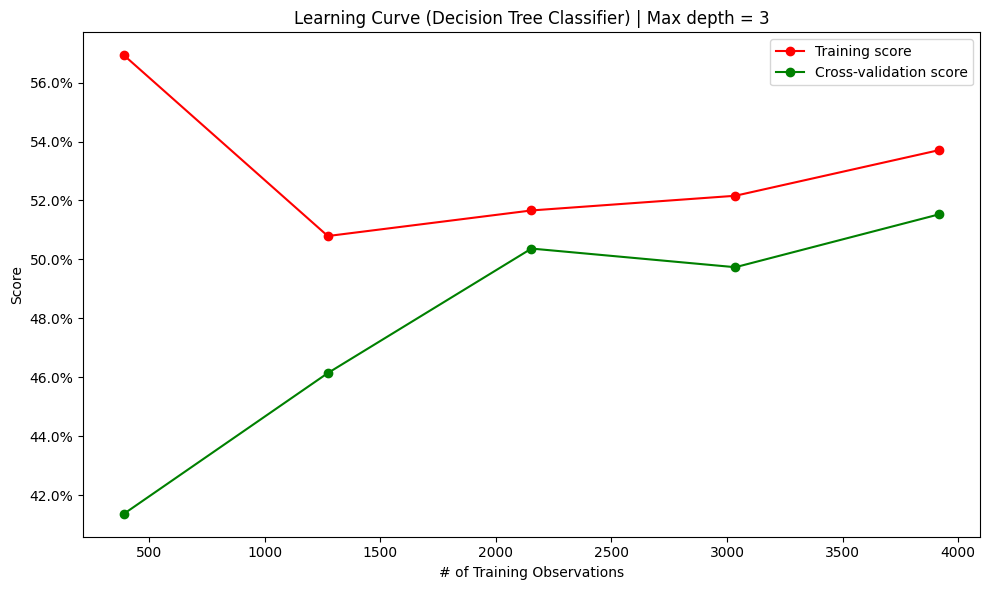

In [206]:
wine_dt.plot_learning_curve(X, y, param_name = "max_depth", dataset_name = 'winequality-white', save_plot=False, show_plot=True)

Folder is already there
/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/winequality_white_DTClassifier_validation_curve.png
New Parameters Set: {'max_depth': 3}
Folder is already there
/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/winequality_white_DTClassifier_learning_curve.png


{'DTClassifier': {'DTClassifier_max_depth': 2}}

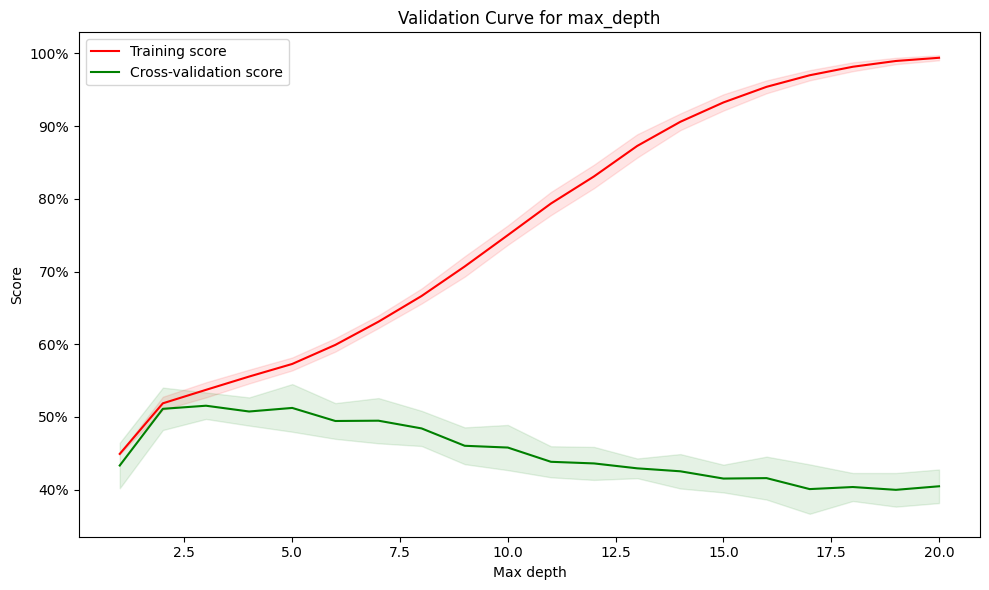

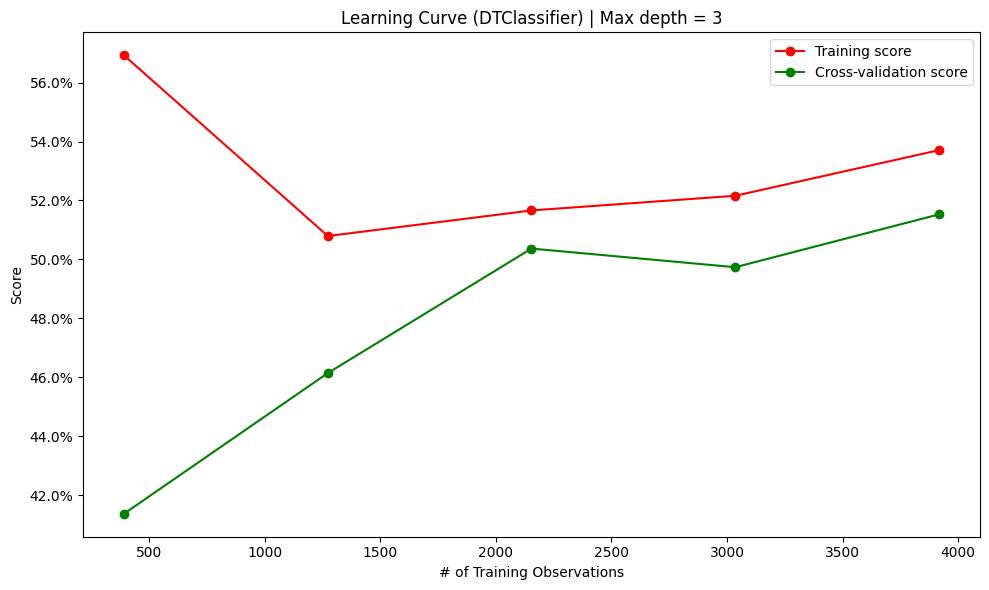

In [228]:
class MLExperimentRunner():
    def __init__(
        self,
        model_class: Type[Union[BaseClassifier, BaseEstimator]],
        data: Dataset,
        config: Type[Config],
        eval_metric: str,
        param_grid: Dict[str, float],
    ):
        self.model_class = model_class
        self.model = None
        self.data = data
        self.config = config
        self.param_grid = param_grid
        self.eval_metric = eval_metric
        self.seed = config.RANDOM_SEED
        self.verbose = config.VERBOSE

    def init_estimator(self) -> Union[BaseClassifier, BaseEstimator]:
        return self.model_class(self.config, self.eval_metric, self.param_grid)

    @property
    def base_experiment_name(self) -> str:
        # Check if underlying model has been instantiated
        if not self.model:
            self.model = self.init_estimator()
        
        return f"{self.model.name}_{self.data.name}"

    def save_training_results(self, learner: BaseEstimator) -> None:
        pass

    def save_test_results(self, learner: BaseEstimator) -> None:
        pass

    def log(self, msg, *args):
        """
        If the experiment is set to Verbose = True, log the message and the passed in arguments
        """
        if self._verbose:
            logger.info(msg.format(*args))

    def run_experiment(self, X: np.array, y: np.array, param_name: str, param_range: float, verbose = False) -> None:
        experiment_times = {}
        
        if verbose:
            logger.info(f"Running Experiment: {self.model.name} | Parameter Name: {param_name} = {list(param_range)}")
        
        start = datetime.now()
        
        estimator = self.model_class(self.config, self.param_grid, self.eval_metric)
        if verbose:
            logger.info(estimator.get_params())
            
        scoring_func = estimator.get_scorer(self.eval_metric)
        
        best_param_value = estimator.plot_validation_curve(
            X,
            y,
            dataset_name=self.data.name,
            param_name=param_name,
            param_range=param_range,
            save_plot=True,
        )
    
        estimator.set_params(max_depth=best_param_value)
        estimator.plot_learning_curve(
            X, y, param_name=param_name, dataset_name=self.data.name, save_plot=True
        )
        end = datetime.now()
        run_time = end - start

        experiment_times[f"{estimator.name}_{param_name}"] = run_time.seconds
        return experiment_times
    
    def main(self) -> Dict[str, float]:
        self.model = self.init_estimator()
        
        logger.info(f"Starting Experiments for: {self.model.name} | Dataset Name: {self.data.name}")
        experiment_details = {}
        for param_name, param_range in self.param_grid.items():
            experiment_details[self.model.name] = self.run_experiment(X, y, param_name, param_range, self.verbose)

        return experiment_details
        


#############################################################################
eval_metric = 'accuracy'

# Outlines what experiments we want to run. These get passed to the underlying estimator
param_grid = {
    'max_depth': np.arange(1, 21),
    # 'ccp_alpha': np.arange(0.1, 1, 0.1),
    # 'min_samples_per_leaf': np.arange(1, 101, 10),
}
# print(param_grid)
dt_experiment = MLExperimentRunner(DTClassifier, wine_data, config, eval_metric, param_grid)
# dt_experiment.experiment_name

# dt_experiment.run_experiment(X.values, y.values, 'max_depth', np.arange(1, 21), verbose = True)
exp_details = dt_experiment.main()
exp_details

In [293]:
import argparse
parser = argparse.ArgumentParser(
    prog="ML Experiment Runner", description="Perform some ML experiments"
)
parser.add_argument(
    "--dt", action="store_true", help="Run the Decision Tree experiment"
)
parser.add_argument("--ann", action="store_true", help="Run the ANN experiment")
parser.add_argument(
    "--boosting", action="store_true", help="Run the Gradient Boosting experiment"
)

parser.add_argument("--knn", action="store_true", help="Run the KNN experiment")
parser.add_argument("--svm", action="store_true", help="Run the SVM experiment")
parser.add_argument("--all", action="store_true", help="Run all experiments")
parser.add_argument(
    "--verbose", action="store_true", help="If true, provide verbose output"
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="Random seed to set for non-determinstic portions of the experiments",
)

parser.add_argument(
    "--threads",
    type=int,
    default=-1,
    help="Number of threads (defaults to -1)",
)

parser.add_argument(
    "-d",
    "--dry-run",
    action="store_true",
    help="Dry run. Only reports passed in CLI arguments",
)

_StoreTrueAction(option_strings=['-d', '--dry-run'], dest='dry_run', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='Dry run. Only reports passed in CLI arguments', metavar=None)

In [300]:
# args = parser.parse_args()
# verbose = args.verbose

# config = Config(verbose=verbose)

args = parser.parse_args(['--dt', '--verbose', '-d'])


cli_args = args._get_kwargs()


In [306]:
print(np.arange(0,20).tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [49]:
def build_pipeline(model, numeric_features, categorical_features, scale_features=False, normalize_features=False, scale_target=False, normalize_target=False):
    # Check scaling and normalization flags
    if scale_features and normalize_features:
        raise ValueError("Both scale_features and normalize_features cannot be True at the same time.")
    if scale_target and normalize_target:
        raise ValueError("Both scale_target and normalize_target cannot be True at the same time.")
    
    # Preprocessing for numeric features
    numeric_transformer = []
    if scale_features:
        numeric_transformer.append(('scaler', StandardScaler()))
    elif normalize_features:
        numeric_transformer.append(('scaler', MinMaxScaler()))
        
    numeric_transformer = Pipeline(steps=numeric_transformer)
    
    # Preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create pipeline
    steps = [('preprocessor', preprocessor), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # Optionally scale the target
    if scale_target or normalize_target:
        target_scaler = TargetScaler(method='standard' if scale_target else 'minmax')
        pipeline = Pipeline(steps=[('target_scaler', target_scaler), ('pipeline', pipeline)])
    
    return pipeline